### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [2]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [3]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [4]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


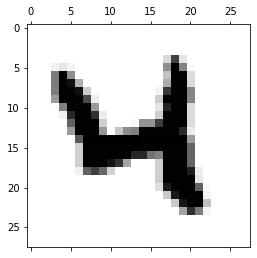

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [5]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [7]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc']) #acc = accuracy, calculates how often predictions equal labels. This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. This frequency is ultimately returned as binary accuracy: an idempotent operation that simply divides total by count
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [8]:
# training parameters
#batch_size è impostato a 50, il che significa che durante l'addestramento il modello riceverà in parallelo un batch di 50 campioni alla volta. Una volta che tutti i campioni all'interno di un batch sono stati elaborati, i pesi vengono aggiornati. epochs è impostato a 20, il che significa che l'intero set di dati di addestramento verrà presentato al modello per 20 volte. Durante ogni epoch, il set di dati di addestramento viene diviso in batch di dimensione batch_size e il modello viene aggiornato dopo ogni batch. In sintesi, l'addestramento di una rete neurale avviene attraverso l'iterazione di un certo numero di epoch, e durante ogni epoch i campioni vengono presentati al modello in batch
batch_size = 50
epochs = 50

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

2023-07-13 15:59:08.372150: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/50
1200/1200 [==============================] - 14s 10ms/step - loss: 0.9284 - acc: 0.7264 - val_loss: 0.3863 - val_acc: 0.9006
Epoch 2/50
1200/1200 [==============================] - 12s 10ms/step - loss: 0.4645 - acc: 0.8674 - val_loss: 0.2917 - val_acc: 0.9190
Epoch 3/50
1200/1200 [==============================] - 11s 9ms/step - loss: 0.3810 - acc: 0.8918 - val_loss: 0.2502 - val_acc: 0.9282
Epoch 4/50
1200/1200 [==============================] - 9s 8ms/step - loss: 0.3286 - acc: 0.9060 - val_loss: 0.2208 - val_acc: 0.9355
Epoch 5/50
1200/1200 [==============================] - 12s 10ms/step - loss: 0.2967 - acc: 0.9163 - val_loss: 0.2038 - val_acc: 0.9403
Epoch 6/50
1200/1200 [==============================] - 11s 9ms/step - loss: 0.2707 - acc: 0.9241 - val_loss: 0.1844 - val_acc: 0.9453
Epoch 7/50
1200/1200 [==============================] - 11s 9ms/step - loss: 0.2514 - acc: 0.9296 - val_loss: 0.1708 - val_acc: 0.9496
Epoch 8/50
1200/1200 [==============================]

#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 [==============================] - 1s 2ms/step - loss: 0.0638 - acc: 0.9786

Test loss: 0.06377146393060684
Test accuracy: 0.978600025177002


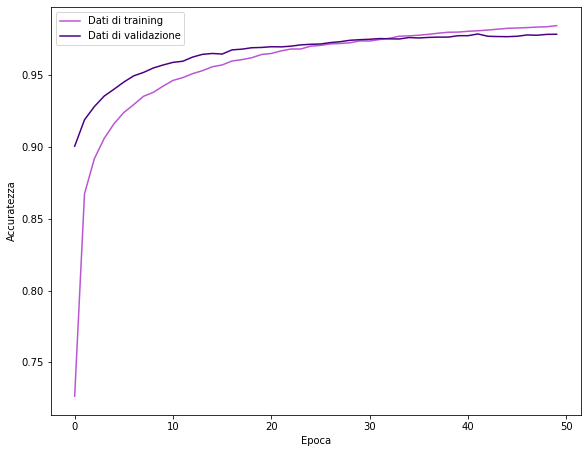

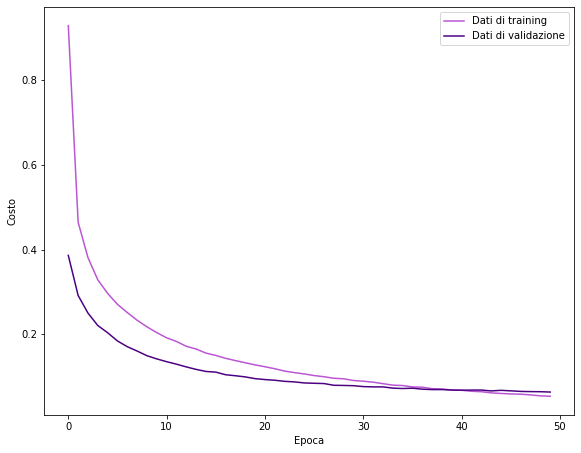

In [9]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history
plt.figure(figsize=(9.5, 7.5))
# summarize history for accuracy
plt.plot(history.history['acc'], color = 'mediumorchid')
plt.plot(history.history['val_acc'], color = 'indigo')
plt.ylabel('Accuratezza')
plt.xlabel('Epoca')
plt.legend(['Dati di training', 'Dati di validazione'], loc='best')
plt.show()

plt.figure(figsize=(9.5, 7.5))
# summarize history for loss
plt.plot(history.history['loss'], color = 'mediumorchid')
plt.plot(history.history['val_loss'], color = 'indigo')
plt.ylabel('Costo')
plt.xlabel('Epoca')
plt.legend(['Dati di training', 'Dati di validazione'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 [==============================] - 1s 1ms/step


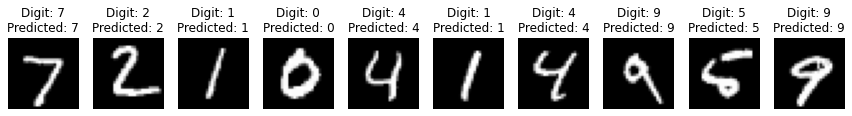

In [10]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adequate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.



### Esercizio 12.1 - Soluzione proposta

Si è allenata la _Deep Neural Network_ per un numero di epoche pari a $50$, sfruttando $4$ diversi ottimizzatori forniti da Keras:
1. _SGD_ (_Stochastic Gradient Descent_);

2. _Adam_ (_Adaptive Moment Estimation_): _Adam_ adatta automaticamente il _learning rate_ in base ai gradienti calcolati per ciascun peso e mostra buone prestazioni in una varietà di problemi di apprendimento automatico;

3. _RMSprop_ (_Root Mean Square Propagation_): _RMSprop_ adatta il _learning rate_ in base alle stime del momento del secondo ordine dei gradienti. Rispetto ad Adam, RMSprop tende a dare più peso ai gradienti recenti rispetto ai gradienti passati;

4. _Adagrad_ (_Adaptive Gradient Algorithm_): _Adagrad_ adatta il learning rate per ciascun parametro in base alla somma dei gradienti passati;

Le stime della funzione di costo e dell'accuratezza risultano essere, per ciascun ottimizzatore:

1. Test loss: 0.06377146393060684 <br>
   Test accuracy: 0.978600025177002
   
2. Test loss: 0.09547776728868484 <br>
   Test accuracy: 0.9829000234603882
   
3. Test loss: 0.21304135024547577 <br>
   Test accuracy: 0.9790999889373779
   
4. Test loss: 0.2272707223892212 <br>
   Test accuracy: 0.9358000159263611

Complessivamente, lo _Stochastic Gradient Descent_ è risultato l'ottimizzatore migliore.

Si è notato che _Adam_ e _Adagrad_ non hanno riconosciuto la cifra 5, predicendola invece come 6, mentre _RMSprop_ e _SGD_ l'hanno predetta correttamente.



#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [11]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

### Esercizio 12.2 - Soluzione proposta

Si è creata una _Deep Neural Network_ costituita anche da strati convoluzionali.

La _DCNN_ è stata allenata per $25$ epoche, sfruttando _SGD_ come ottimizzatore e _reLU_ come funzione di attivazione.

In [12]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
        
    model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))#Max pooling operation for 2D spatial data. Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input
    model.add(Dropout(0.25)) #Dropout layers help to reduce overfitting by randomly dropping a fraction of the input units during training
    model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))#Max pooling operation for 2D spatial data. Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input
    model.add(Flatten()) #Flattens the input. Does not affect the batch size.
    model.add(Dense(128, activation='relu')) #Add fully connected dense layers to perform classification. Different numbers of neurons in these layers
    model.add(Dense(10, activation='softmax')) #Softmax converts a vector of values to a probability distribution. The elements of the output vector are in range (0, 1) and sum to 1
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [13]:
# training parameters
batch_size = 32
epochs = 25

# create the deep conv net
model_CNN=create_CNN()

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25


2023-07-13 16:12:18.200951: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 24s 12ms/step - loss: 0.5819 - acc: 0.8140 - val_loss: 0.1859 - val_acc: 0.9461
Epoch 2/25
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1810 - acc: 0.9439 - val_loss: 0.1178 - val_acc: 0.9626
Epoch 3/25
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1206 - acc: 0.9633 - val_loss: 0.0772 - val_acc: 0.9752
Epoch 4/25
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0937 - acc: 0.9710 - val_loss: 0.0624 - val_acc: 0.9807
Epoch 5/25
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0804 - acc: 0.9747 - val_loss: 0.0565 - val_acc: 0.9825
Epoch 6/25
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0689 - acc: 0.9790 - val_loss: 0.0490 - val_acc: 0.9847
Epoch 7/25
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0614 - acc: 0.9811 - val_loss: 0.0450 - val_acc: 0.9860
Epoch 8/25
1875/1875 [==============================] - 24s

313/313 [==============================] - 1s 3ms/step - loss: 0.0339 - acc: 0.9896

Test loss: 0.033935967832803726
Test accuracy: 0.9896000027656555


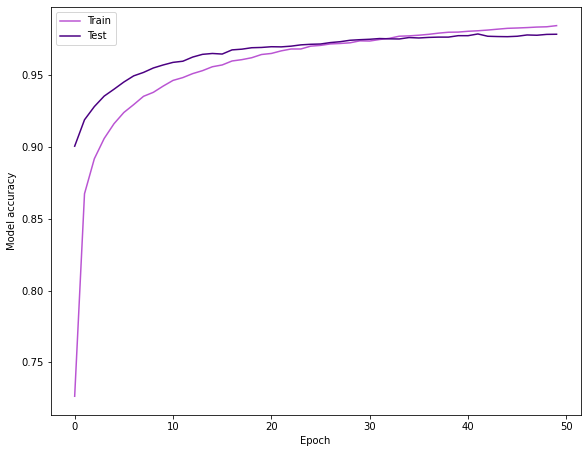

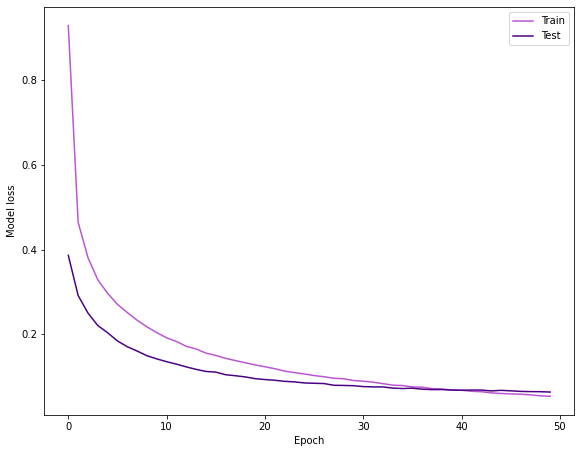

In [14]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history
plt.figure(figsize=(9.5, 7.5))
# summarize history for accuracy
plt.plot(history.history['acc'], color = 'mediumorchid')
plt.plot(history.history['val_acc'], color = 'indigo')
plt.ylabel('Model accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

plt.figure(figsize=(9.5, 7.5))
# summarize history for loss
plt.plot(history.history['loss'], color = 'mediumorchid')
plt.plot(history.history['val_loss'], color = 'indigo')
plt.ylabel('Model loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

313/313 [==============================] - 1s 3ms/step


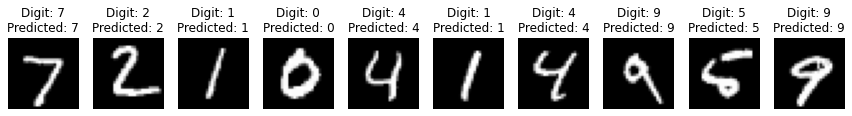

In [15]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

### Esercizio 12.3 - Soluzione proposta

Sono in seguito riportate le cifre disegnate, con le rispettive predizioni della _Convolutional Neural Network_.

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 21ms/step


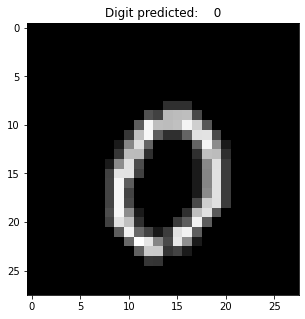

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 18ms/step


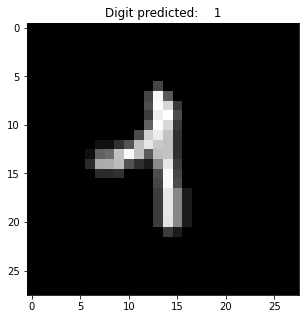

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 17ms/step


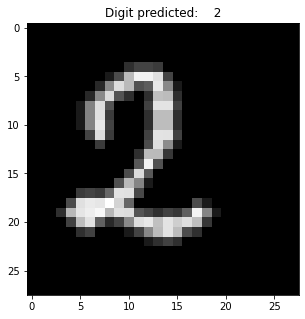

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 16ms/step


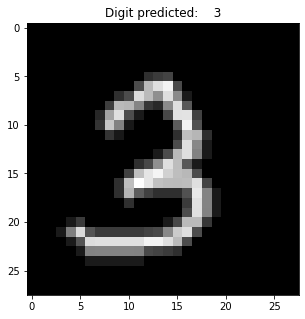

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 16ms/step


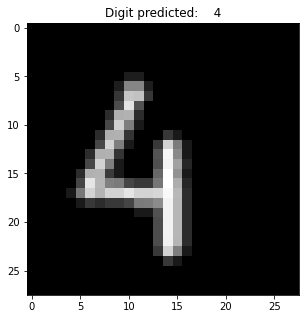

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 17ms/step


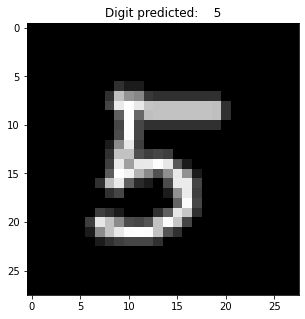

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 26ms/step


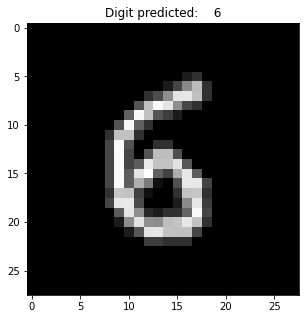

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 19ms/step


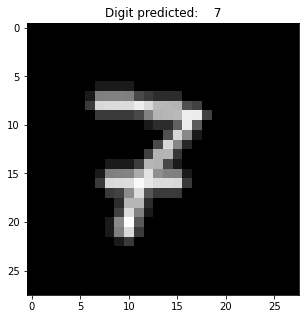

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 21ms/step


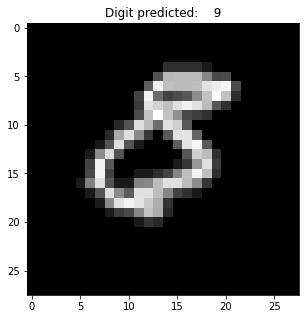

Image size: 28x28
(28, 28)
(1, 28, 28, 1)
1/1 [==============================] - 0s 17ms/step


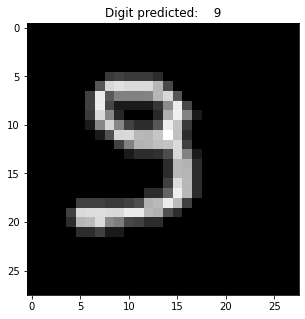

In [16]:
from PIL import Image
import os

def digit(filename):
    digit_in = Image.open(filename).convert('L')

    ydim, xdim = digit_in.size
    print("Image size: " + str(xdim) + "x" + str(ydim))

    pix = digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = pix[j, i]

    data /= 255

    print(data.shape)

    data = data.reshape(1, xdim, ydim, 1)    # reshape data for CNN model
    print(data.shape)
    
    pred_0 = model_CNN.predict(data)   # model prediction

    data = data.reshape(xdim, ydim)   # reshape for printing the image

    plt.figure(figsize=(5, 5))
    plt.imshow(data, cmap='gray')
    plt.title("Digit predicted:    {}".format(np.argmax(pred_0)))
    plt.show()

# process digit from 0 to 9
for i in range(10):
    digit_filename = "Es12/{}.png".format(i)
    digit(digit_filename)